In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from custom_transformers import (
    DropRedundantColumns,
    CreateNewFeature,
    ReplaceClassTransformer,
)

In [14]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import f1_score
from utils_machine_learning import rename_columns_to_snake_case
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler,
    OrdinalEncoder, 
    PowerTransformer, 
    FunctionTransformer,
    MinMaxScaler,
    )
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [3]:
import dill
def load_object(file_path: str) -> object:
        print("Entered the load_object method of MainUtils class")
        try:
            with open(file_path, "rb") as file_obj:
                obj = dill.load(file_obj)
            print(f"Successfully loaded the object from {file_path}")
            print("Exited the load_object method of MainUtils class")
            return obj
        except Exception as e:
            raise e

In [4]:
obj = load_object('insurance_claim_fraud_model.pkl')

Entered the load_object method of MainUtils class
Successfully loaded the object from insurance_claim_fraud_model.pkl
Exited the load_object method of MainUtils class


In [9]:
for item in obj:
    print(f"{item}")

DecisionTree
{'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 17, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'mean', 'outlier_strategy': 'power_transform', 'resampler': 'RandomUnderSampler', 'scaler': 'standard', 'dim_red': None}
0.656


In [15]:
# load the dataset
def load_dataset() -> pd.DataFrame:
    """
    Load the dataset from the CSV file and return it as a pandas DataFrame.

    Args:
        None

    Returns:
        pd.DataFrame: The dataset loaded from the CSV file.
    """
    
    data_path = 'https://github.com/donadviser/datasets/raw/master/data-don/auto_insurance_claim_fraud.csv'
    data = pd.read_csv(data_path, sep=",")
    return (data
            .pipe(rename_columns_to_snake_case)
            #.dropna()
            )

In [16]:
data_raw = load_dataset()
data_raw.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [215]:
categorical_columns = [
  "policy_state", 
  "policy_csl" ,
  "insured_sex" ,
  "insured_education_level", 
  'insured_occupation', 
  "insured_hobbies", 
  'insured_relationship', 
  'incident_type', 
  'collision_type', 
  'incident_severity', 
  'authorities_contacted', 
  'incident_state', 
  'incident_city', 
  'property_damage', 
  'police_report_available', 
  'auto_make', 
  'policy_deductable', 
  'number_of_vehicles_involved', 
  'bodily_injuries', 
  'witnesses',
  'incident_hour_of_the_day'
]
print(categorical_columns)

['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'property_damage', 'police_report_available', 'auto_make', 'policy_deductable', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'incident_hour_of_the_day']


In [216]:
onehot_features =[
 'policy_state',
 'collision_type',
 'property_damage',
 'police_report_available',
 'insured_sex',
 'insured_education_level',
 'insured_relationship',
 'incident_type',
 'incident_severity',
 'authorities_contacted',
 'incident_state',
 'incident_city',
 'policy_deductable',
 'number_of_vehicles_involved',
 'bodily_injuries',
 'witnesses',
 'incident_period_of_day',
 ]
print(onehot_features)

['policy_state', 'collision_type', 'property_damage', 'police_report_available', 'insured_sex', 'insured_education_level', 'insured_relationship', 'incident_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'policy_deductable', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'incident_period_of_day']


In [20]:
numerical_features = ['months_as_customer',
 'age',
 'policy_annual_premium',
 'injury_claim',
 'property_claim',
 'vehicle_claim',
 'vehicle_age',
]

ordinal_features = ['insured_occupation', 'insured_hobbies', 'auto_make']

transform_features = ['umbrella_limit', 'capital_gains', 'capital_loss']

drop_columns = [
    'policy_number',
    'policy_bind_date',
    'policy_csl',
    'insured_zip',
    'incident_date',
    'incident_location',
    'auto_model',
    'auto_year',
    'incident_hour_of_the_day',
    'total_claim_amount'
    ]

In [22]:
numerical_columns=['months_as_customer',
 'age',
 'policy_number',
 'policy_annual_premium',
 'umbrella_limit',
 'insured_zip',
 'capital_gains',
 'capital_loss',
 'total_claim_amount',
 'injury_claim',
 'property_claim',
 'vehicle_claim',
 'auto_year']

In [23]:
target_col = 'fraud_reported'

In [24]:
# Assuming dataset is loaded in a pandas dataframe
X, y = data_raw.drop(columns=[target_col]), data_raw[target_col]

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:

print(f"Length of columns in X_train: {len(X.columns)} \n Columns are:\n {X.columns}")

Length of columns in X_train: 38 
 Columns are:
 Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital_gains', 'capital_loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year'],
      dtype='object')


In [45]:
all_features = numerical_columns+onehot_features+ordinal_features+transform_features
all_features =  [col for col in all_features if col not in drop_columns]
print(f"Length of all_features: {len(all_features)} \n Features are:\n {all_features}")

Length of all_features: 32 
 Features are:
 ['months_as_customer', 'age', 'policy_annual_premium', 'umbrella_limit', 'capital_gains', 'capital_loss', 'injury_claim', 'property_claim', 'vehicle_claim', 'policy_state', 'collision_type', 'property_damage', 'police_report_available', 'insured_sex', 'insured_education_level', 'insured_relationship', 'incident_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'policy_deductable', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'incident_period_of_day', 'insured_occupation', 'insured_hobbies', 'auto_make', 'umbrella_limit', 'capital_gains', 'capital_loss']


In [25]:
bins_hour = [-1, 5, 11, 17, 20, 24]  # Time bins for different periods of the day
names_period = ["early_morning", "morning", "afternoon", "evening", "night"] 

In [14]:
# Define the consolidated ColumnTransformer with imputers and scaling
preprocessor = Pipeline([

    # Custom feature engineering steps
    ('create_new_features', CreateNewFeature(bins_hour=bins_hour, names_period=names_period)),
    ('drop_cols', DropRedundantColumns(redundant_cols=drop_columns)),

    # Consolidated ColumnTransformer for all feature transformations with imputers and scaling
    ('column_transformer', ColumnTransformer(
        transformers=[
            # Numerical features: Imputation followed by Scaling
            ('numerical', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),  # Mean imputation for numerical features
                ('scaler', MinMaxScaler())  # Apply MinMaxScaler to numerical features
            ]), numerical_features),

            # Categorical features: Imputation followed by OneHot Encoding
            ('categorical', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode (most frequent) imputation for categorical features
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), onehot_features),

            # Ordinal features: Imputation followed by Ordinal Encoding
            ('ordinal', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode imputation for ordinal features
                ('ordinal', OrdinalEncoder())
            ]), ordinal_features),

            # Features requiring power transformation: Imputation followed by PowerTransformer
            ('power_transform', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),  # Mean imputation for features needing power transformation
                ('power_transformer', PowerTransformer(method='yeo-johnson'))
            ]), transform_features),
        ],
        remainder='passthrough'  # Pass through any other features that aren't transformed
    ))
])



In [15]:
preprocessor

Pipeline(steps=[('create_new_features',
                 CreateNewFeature(bins_hour=[-1, 5, 11, 17, 20, 24],
                                  names_period=['early_morning', 'morning',
                                                'afternoon', 'evening',
                                                'night'])),
                ('drop_cols',
                 DropRedundantColumns(redundant_cols=['policy_number',
                                                      'policy_bind_date',
                                                      'policy_csl',
                                                      'insured_zip',
                                                      'incident_date',
                                                      'incident_location',
                                                      'auto_model', 'auto_year',
                                                      'incident_hour_of_t...
                                                   'incident_period_of_day']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['insured_occupation',
                                                   'insured_hobbies',
                                                   'auto_make']),
                                                 ('power_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('power_transformer',
                                                                   PowerTransformer())]),
                                                  ['umbrella_limit',
                                                   'capital_gains',
                                                   'capital_loss'])]))])

In [16]:
X_transformed = preprocessor.fit_transform(X)

In [17]:
#X_transformed.isnull().sum()

In [18]:
try:
    print(f"Length of columns in X_transformed: {len(X_transformed.columns)} \n Columns are:\n {X_transformed.columns}")
except Exception as e:
    print(f"X_transformed length: {len(X_transformed)}\n Samples are:\n {X_transformed[:,5:10]}")

X_transformed length: 1000
 Samples are:
 [[0.65429614 0.55       0.         0.         1.        ]
 [0.04327588 0.4        0.         1.         0.        ]
 [0.28972198 0.4        0.         0.         1.        ]
 ...
 [0.65957982 0.95       0.         0.         1.        ]
 [0.45879985 0.85       1.         0.         0.        ]
 [0.04541452 0.4        0.         0.         1.        ]]


In [19]:
X_transformed.shape

(1000, 86)

In [20]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [21]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [22]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(random_state=42), 
     #"CatBoosting Classifier": CatBoostClassifier(verbose=False, random_state=42),
     "Support Vector Classifier": SVC(random_state=42),
    "AdaBoost Classifier": AdaBoostClassifier(random_state=42)

}

In [23]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    auc= []
    results_train = []
    results_test = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])
        
        # Append evaluation train results
        results_train.append({
            'Classifier': list(models.keys())[i],
            'Accuracy': model_train_accuracy,
            'Precision': model_train_precision,
            'Recall': model_train_recall,
            'F1-Score': model_train_f1,
            'ROC AUC': model_train_rocauc_score,
        })
        
        # Append evaluation text results
        results_test.append({
            'Classifier': list(models.keys())[i],
            'Accuracy': model_test_accuracy,
            'Precision': model_test_precision,
            'Recall': model_test_recall,
            'F1-Score': model_test_f1,
            'ROC AUC': model_test_rocauc_score,
        })

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
    
    return results_train, results_test

In [24]:
# Assuming dataset is loaded in a pandas dataframe
X, y = data_raw.drop(columns=[target_col]), data_raw[target_col]

X_transformed = preprocessor.fit_transform(X)

from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_transformed, y)

In [25]:
y_res.unique()

array(['N', 'Y'], dtype=object)

In [26]:
# During training, map target labels
y_res = y_res.map({'Y': 1, 'N': 0})

In [27]:
y_res.unique()

array([0, 1])

In [28]:
base_model_report =evaluate_models(X=X_res, y=y_res, models=models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9244
- F1 score: 0.9547
- Precision: 0.9384
- Recall: 0.9716
- Roc Auc Score: 0.8407


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.8488
- F1 score: 0.9051
- Precision: 0.9323
- Recall: 0.8794
- Roc Auc Score: 0.7946


Gradient Boosting
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9186
- F1 score: 0.9500
- Precision: 0.9568
- Recall: 0.9433
- Roc Auc Score: 0.8749




/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_insure/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Model performance for Training set
- Accuracy: 0.9225
- F1 score: 0.9543
- Precision: 0.9294
- Recall: 0.9805
- Roc Auc Score: 0.8152
----------------------------------
Model performance for Test set
- Accuracy: 0.8488
- F1 score: 0.9091
- Precision: 0.8966
- Recall: 0.9220
- Roc Auc Score: 0.7191


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9488
- F1 score: 0.9699
- Precision: 0.9416
- Recall: 1.0000
- Roc Auc Score: 0.8542
----------------------------------
Model performance for Test set
- Accuracy: 0.9012
- F1 score: 0.9431
- Precision: 0.8924
- Recall: 1.0000
- Roc Auc Score: 0.7258


XGBClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9709
- F1 score: 0.9822
- Precision: 0.9857
- Recall: 0.9787
- Roc Auc Score: 0.9571


Support Vector Classifier
Model performa

/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_insure/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [29]:
# Assuming dataset is loaded in a pandas dataframe
X, y = data_raw.drop(columns=[target_col]), data_raw[target_col]

X_transformed = preprocessor.fit_transform(X)

# Splitting the dataset
# During training, map target labels
y = y.map({'Y': 1, 'N': 0})
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [30]:
y_res.unique()

array([0, 1])

In [31]:
# Define SMOTEENN resampler
smoteenn = SMOTEENN()

# Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBClassifier': xgb.XGBClassifier(eval_metric='logloss', random_state=42)
}

In [32]:
# Initialize a list to keep model performance scores
# Initialize a list to keep model performance scores
model_performance = []

# Define the SMOTENN for resampling
smoteenn = SMOTEENN()

# Train models and select top N models based on F1-score
for name, clf in classifiers.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # This should be a transformer, not a pipeline
        #('resample', smoteenn),
        ('classifier', clf)
    ])
    
    # Perform cross-validation to evaluate F1-score
    f1 = cross_val_score(pipeline, X_train, y_train.values.reshape(-1, 1), scoring='f1', cv=5).mean()
    model_performance.append((name, f1))

# Sort models by F1 score and get top N models
n_top = 3
top_models = sorted(model_performance, key=lambda x: x[1], reverse=True)[:n_top]

# Print the top models
for model in top_models:
    print(f"Model: {model[0]}, F1 Score: {model[1]}")


'numpy.ndarray' object has no attribute 'assign'
'NoneType' object has no attribute 'drop'
'numpy.ndarray' object has no attribute 'assign'
'NoneType' object has no attribute 'drop'
'numpy.ndarray' object has no attribute 'assign'
'NoneType' object has no attribute 'drop'
'numpy.ndarray' object has no attribute 'assign'
'NoneType' object has no attribute 'drop'
'numpy.ndarray' object has no attribute 'assign'
'NoneType' object has no attribute 'drop'



KeyboardInterrupt



In [ ]:
pipeline

In [162]:
# Assuming dataset is loaded in a pandas dataframe
X, y = data_raw.drop(columns=[target_col]), data_raw[target_col]

X_transformed = preprocessor.fit_transform(X)

# Splitting the dataset
# During training, map target labels
y = y.map({'Y': 1, 'N': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [177]:
preprocessor_steps = [
        # Custom feature engineering steps
        ('create_new_features', CreateNewFeature(bins_hour=bins_hour, names_period=names_period)),
        ('drop_cols', DropRedundantColumns(redundant_cols=drop_columns)),
        
        # Column transformer for scaling, imputing, and encoding features
        ('column_transformer', ColumnTransformer(
            transformers=[
                # Numerical features: Imputation followed by Scaling
                ('numerical', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='mean')),  # Mean imputation for numerical features
                    ('scaler', MinMaxScaler())  # Apply MinMaxScaler to numerical features
                ]), numerical_features),

                # Categorical features: Imputation followed by OneHot Encoding
                ('categorical', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode (most frequent) imputation for categorical features
                    ('onehot', OneHotEncoder(handle_unknown='ignore'))
                ]), onehot_features),

                # Ordinal features: Imputation followed by Ordinal Encoding
                ('ordinal', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode imputation for ordinal features
                    ('ordinal', OrdinalEncoder())
                ]), ordinal_features),

                # Features requiring power transformation: Imputation followed by PowerTransformer
                ('power_transform', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='mean')),  # Mean imputation for features needing power transformation
                    ('power_transformer', PowerTransformer(method='yeo-johnson'))
                ]), transform_features),
            ],
            remainder='passthrough'  # Pass through any other features that aren't transformed
        )),
]     

In [178]:
# Create the preprocessor pipeline
preprocessor = ImbPipeline(steps=preprocessor_steps)


In [ ]:
preprocessor

In [240]:
# Assuming dataset is loaded in a pandas dataframe
X, y = data_raw.drop(columns=[target_col]), data_raw[target_col]

# Splitting the dataset
# During training, map target labels
y = y.map({'Y': 0, 'N': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the main pipeline with all preprocessing, resampling, and classifier steps
classifiers = {
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=10),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000),
    "K-NeighborsClassifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(random_state=42), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False, random_state=42),
    "SupportVectorClassifier": SVC(random_state=42, probability=True),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=42, algorithm='SAMME')
}

# Initialize a list to store model performance scores
model_performance = []

# Define the SMOTENN for resampling
smoteenn = SMOTEENN()

model_performance = []
# Loop through each classifier, create a pipeline, and evaluate it
for name, clf in classifiers.items():

    # Define the complete pipeline with all transformations
    pipeline = ImbPipeline(steps=[
        # Custom feature engineering steps
        ('create_new_features', CreateNewFeature(bins_hour=bins_hour, names_period=names_period)),
        ('drop_cols', DropRedundantColumns(redundant_cols=drop_columns)),
        
        # Column transformer for scaling, imputing, and encoding features
        ('column_transformer', ColumnTransformer(
            transformers=[
                # Numerical features: Imputation followed by Scaling
                ('numerical', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='mean')),  # Mean imputation for numerical features
                    #('scaler', StandardScaler())  # Apply MinMaxScaler to numerical features
                ]), numerical_features),

                # Categorical features: Imputation followed by OneHot Encoding
                ('categorical', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode (most frequent) imputation for categorical features
                    ('onehot', OneHotEncoder(handle_unknown='ignore'))
                ]), onehot_features),

                # Ordinal features: Imputation followed by Ordinal Encoding
                ('ordinal', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode imputation for ordinal features
                    ('ordinal', OrdinalEncoder())
                ]), ordinal_features),

                # Features requiring power transformation: Imputation followed by PowerTransformer
                ('power_transform', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='mean')),  # Mean imputation for features needing power transformation
                    ('power_transformer', PowerTransformer(method='yeo-johnson'))
                ]), transform_features),
            ],
            #remainder='passthrough'  # Pass through any other features that aren't transformed
        )),
        ('all_scaled', StandardScaler()),
        
        # Resampling step using SMOTENN
        ('resample', smoteenn),
        
        # Classification step
        ('classifier', clf)
    ])
    
    # Perform cross-validation to evaluate F1-score
    scores = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=5, error_score='raise').mean()
    # Calculate average F1-score
    f1_mean = scores.mean()
    
    # Fit the model on the training data
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate the metrics
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
    
    
    
    # Update metrics dictionary
    model_performance.append({
        'model_name':name,
        'f1_cv': f1_mean,
        'f1_score': f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc        
    })

# Create DataFrame from metrics dictionary
df_metrics = pd.DataFrame(model_performance)

In [ ]:
df_metrics.sort_values(by='roc_auc', ascending=False)

In [ ]:
pipeline

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

In [49]:
# Assuming dataset is loaded in a pandas dataframe
X, y = data_raw.drop(columns=[target_col]), data_raw[target_col]

# Splitting the dataset
# Map target labels
y = y.map({'Y': 0, 'N': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# Define the classifiers
classifiers = {
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=10),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000),
    "K-NeighborsClassifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(random_state=42),
    "CatBoosting Classifier": CatBoostClassifier(verbose=False, random_state=42),
    "SupportVectorClassifier": SVC(random_state=42, probability=True),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=42, algorithm='SAMME')
}

# Define SMOTENN for resampling
smoteenn = SMOTEENN(random_state=42,sampling_strategy='minority' )

# Initialize a list to store model performance scores
model_performance = []

# Define the pipeline steps
for name, clf in classifiers.items():
    
    # Define the complete pipeline with all transformations
    pipeline = ImbPipeline(steps=[
        # Custom feature engineering steps
        ('create_new_features', CreateNewFeature(bins_hour=bins_hour, names_period=names_period)),
        ('drop_cols', DropRedundantColumns(redundant_cols=drop_columns)),
        ('replace_class', ReplaceClassTransformer(target_value="?", replacement_value='unknown')),
        
        # Column transformer for scaling, imputing, and encoding features
        ('column_transformer', ColumnTransformer(
            transformers=[
                # Numerical features: Imputation followed by Scaling
                ('numerical', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='mean')),  # Mean imputation for numerical features
                ]), numerical_features),

                # Categorical features: Imputation followed by OneHot Encoding
                ('categorical', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode (most frequent) imputation for categorical features
                    ('onehot', OneHotEncoder(handle_unknown='ignore'))
                ]), onehot_features),

                # Ordinal features: Imputation followed by Ordinal Encoding
                ('ordinal', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode imputation for ordinal features
                    ('ordinal', OrdinalEncoder())
                ]), ordinal_features),

                # Features requiring power transformation: Imputation followed by PowerTransformer
                ('power_transform', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='mean')),  # Mean imputation for features needing power transformation
                    ('power_transformer', PowerTransformer(method='yeo-johnson'))
                ]), transform_features),
            ]
        )),
        
        # Standard scaling
        ('all_scaled', StandardScaler()),
        
        # Resampling step using SMOTENN
        ('resample', smoteenn),
        
        # Classification step
        ('classifier', clf)
    ])

    # Perform cross-validation to evaluate the F1-score
    cv_scores = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=5, error_score='raise')
    f1_cv_mean = cv_scores.mean()  # Mean F1 score from cross-validation
    
    # Fit the model on the training data
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate the metrics on the test set
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
    
    # Store the results for each classifier
    model_performance.append({
        'model_name': name,
        'f1_cv': f1_cv_mean,
        'f1_score': f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc
    })

# Create DataFrame from model performance
df_metrics = pd.DataFrame(model_performance)

# Display the results (optional)
print(df_metrics)


                model_name     f1_cv  f1_score  accuracy  precision    recall  \
0             RandomForest  0.387980  0.463918     0.480   0.918367  0.310345   
1             DecisionTree  0.687290  0.672414     0.620   0.896552  0.537931   
2         GradientBoosting  0.650743  0.684211     0.640   0.939759  0.537931   
3       LogisticRegression  0.564925  0.636771     0.595   0.910256  0.489655   
4    K-NeighborsClassifier  0.153066  0.140127     0.325   0.916667  0.075862   
5            XGBClassifier  0.681743  0.767347     0.715   0.940000  0.648276   
6   CatBoosting Classifier  0.552412  0.663717     0.620   0.925926  0.517241   
7  SupportVectorClassifier  0.338082  0.391304     0.440   0.923077  0.248276   
8       AdaBoostClassifier  0.655790  0.672646     0.635   0.961538  0.517241   

    roc_auc  
0  0.748025  
1  0.687147  
2  0.804138  
3  0.717367  
4  0.562884  
5  0.824075  
6  0.792727  
7  0.708715  
8  0.815172  


In [50]:
pipeline

Pipeline(steps=[('create_new_features',
                 CreateNewFeature(bins_hour=[-1, 5, 11, 17, 20, 24],
                                  names_period=['early_morning', 'morning',
                                                'afternoon', 'evening',
                                                'night'])),
                ('drop_cols',
                 DropRedundantColumns(redundant_cols=['policy_number',
                                                      'policy_bind_date',
                                                      'policy_csl',
                                                      'insured_zip',
                                                      'incident_date',
                                                      'incident_location',
                                                      'auto_model', 'auto_year',
                                                      'incident_hour_of_t...
                                                   'insured_hobbies',
                                                   'auto_make']),
                                                 ('power_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('power_transformer',
                                                                   PowerTransformer())]),
                                                  ['umbrella_limit',
                                                   'capital_gains',
                                                   'capital_loss'])])),
                ('all_scaled', StandardScaler()),
                ('resample',
                 SMOTEENN(random_state=42, sampling_strategy='minority')),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME', random_state=42))])

In [153]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np

# Assuming dataset is loaded in a pandas dataframe
X, y = data_raw.drop(columns=[target_col]), data_raw[target_col]

# Splitting the dataset
y = y.map({'Y': 0, 'N': 1})  # Map target labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define classifiers and their respective hyperparameters for tuning
classifiers = {
    "RandomForestClassifier": {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1,),
        'params': {
            'model__n_estimators': [100, 200, 500],
            'model__max_depth': [10, 20, 30],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    },
    "DecisionTreeClassifier": {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'model__max_depth': [10, 20, 30],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    },
    "GradientBoosting": {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5]
        }
    },
    "LogisticRegression": {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'model__C': [0.01, 0.1, 1.0, 10.0]
        }
    },
    "K-NeighborsClassifier": {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 4, 5, 7, 9],
            'model__weights': ['uniform', 'distance'],
            'model__algorithm': ['auto', 'ball_tree', 'kd_tree','brute'],
        }
    },
    
    "XGBClassifier": {
        'model': XGBClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5]
        }
    },
    
    'CatBoostingClassifier': {
        'model': CatBoostClassifier(verbose=False, random_state=42),
        'params': {
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__depth': [4, 6, 8],
            'model__iterations': [100, 200]
        }
    },

    "AdaBoostClassifier": {
        'model': AdaBoostClassifier(random_state=42, algorithm='SAMME'),
        'params': {
            'model__n_estimators': [50, 100],
            'model__learning_rate': [0.01, 0.1, 1.0],
        }
    }
}

# Initialize a list to store model performance scores
model_performance = []

# Define the SMOTENN for resampling
smoteenn = SMOTEENN(random_state=42,sampling_strategy='minority' )

# Loop through each classifier, create a pipeline, perform hyper-parameter tuning, and evaluate
stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=42)
for name, clf_info in classifiers.items():
    print(f"classifier: {name}")
    clf = clf_info['model']
    param_grid = clf_info['params']

    # Define the pipeline with all transformations and resampling
    pipeline = ImbPipeline(steps=[
        ('create_new_features', CreateNewFeature(bins_hour=bins_hour, names_period=names_period)),
        ('replace_class', ReplaceClassTransformer(target_value="?", replacement_value='unknown')),
        ('drop_cols', DropRedundantColumns(redundant_cols=drop_columns)),
        
        # Column transformer for scaling, imputing, and encoding features
        ('column_transformer', ColumnTransformer(
            transformers=[
                ('numerical', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='median')),  # Mean imputation for numerical features
                    ('scaler', StandardScaler())
                ]), numerical_features),
                ('categorical', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode imputation for categorical features
                    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
                ]), onehot_features),
                ('ordinal', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode imputation for ordinal features
                    ('ordinal', OrdinalEncoder())
                ]), ordinal_features),
                ('power_transform', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='median')),  # Mean imputation for features needing power transformation
                    ('power_transformer', PowerTransformer(method='yeo-johnson'))
                ]), transform_features),
            ],
            remainder='passthrough'
        )),
        
        ('resample', smoteenn),
        #('all_scaled', MinMaxScaler()),
        ('model', clf)
    ])

    # RandomizedSearchCV for hyper-parameter tuning
    random_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='roc_auc',  # Scoring can be adjusted as needed
        #n_iter=100,  # Number of iterations for RandomizedSearch
        cv=stratified_kfold,  # 5-fold cross-validation
        #random_state=42,
        n_jobs=-1  # Use all processors
    )

    # Fit the RandomizedSearchCV on the training data
    random_search.fit(X_train, y_train)
    
    cv_score_train = random_search.best_score_
    cv_score_test = random_search.score(X_test, y_test)

    # Predict on the test set using the best model from RandomizedSearch
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Calculate performance metrics
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
    
    # Update model performance dictionary
    model_performance.append({
        'model_name': name,
        #'best_params': random_search.best_params_,
        'cv_score_train': cv_score_train,
        'cv_score_test': cv_score_test,
        'f1_score': f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc        
    })

# Create DataFrame from model performance metrics
df_metrics = pd.DataFrame(model_performance)


classifier: RandomForestClassifier
classifier: DecisionTreeClassifier
classifier: GradientBoosting
classifier: LogisticRegression
classifier: K-NeighborsClassifier
classifier: XGBClassifier
classifier: CatBoostingClassifier
classifier: AdaBoostClassifier


In [73]:
df_metrics.sort_values(by='roc_auc', ascending=False)

,model_name,cv_score_train,cv_score_test,f1_score,accuracy,precision,recall,roc_auc
6,CatBoostingClassifier,0.836130,0.825517,0.813433,0.750,0.931624,0.721854,0.825517
5,XGBClassifier,0.840836,0.798621,0.770992,0.700,0.909910,0.668874,0.798621
2,GradientBoosting,0.831705,0.785647,0.792453,0.725,0.921053,0.695364,0.785647
7,AdaBoostClassifier,0.798990,0.780646,0.739300,0.665,0.896226,0.629139,0.780646
1,DecisionTreeClassifier,0.764200,0.778686,0.798507,0.730,0.914530,0.708609,0.778686
0,RandomForestClassifier,0.767897,0.741587,0.470588,0.460,0.905660,0.317881,0.741587
3,LogisticRegression,0.737492,0.674145,0.644628,0.570,0.857143,0.516556,0.674145
4,K-NeighborsClassifier,0.622214,0.578457,0.335079,0.365,0.800000,0.211921,0.578457


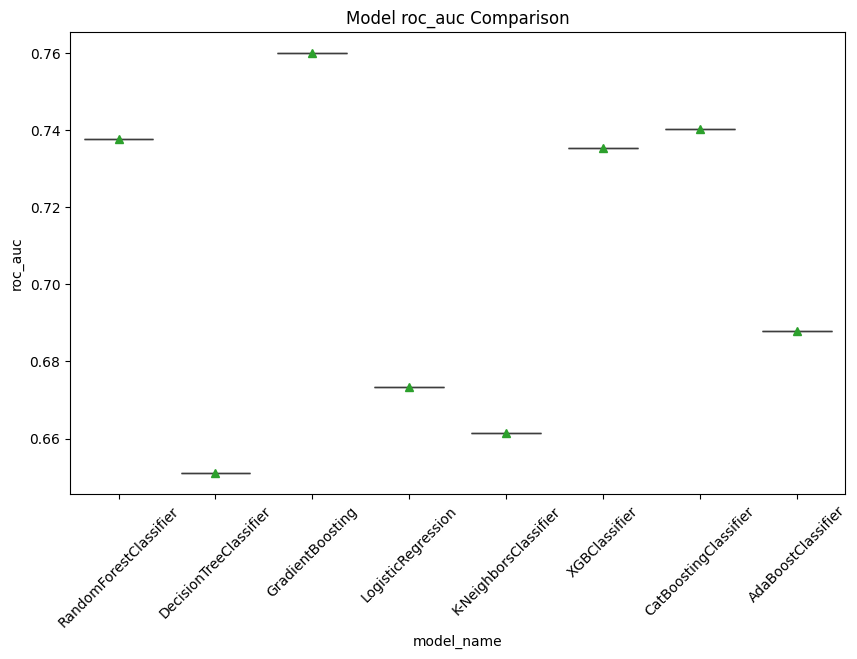

In [45]:
metric_for_comparison = 'roc_auc'
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the boxplot using Seaborn
#sns.boxplot(x='model_name', y=metric_for_comparison, data=df_metrics, showmeans=True)
sns.boxplot(data=df_metrics, x="model_name", y=metric_for_comparison, hue="model_name", fill=True, gap=.1, showmeans=True, showcaps=False,)

# Set plot title and labels
plt.title(f'Model {metric_for_comparison} Comparison')
plt.ylabel(metric_for_comparison)
plt.xlabel('model_name')

# Rotate x-tick labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [68]:
best_model

Pipeline(steps=[('create_new_features',
                 CreateNewFeature(bins_hour=[-1, 5, 11, 17, 20, 24],
                                  names_period=['early_morning', 'morning',
                                                'afternoon', 'evening',
                                                'night'])),
                ('replace_class',
                 ReplaceClassTransformer(replacement_value='unknown',
                                         target_value='?')),
                ('drop_cols',
                 DropRedundantColumns(redundant_cols=['policy_number',
                                                      'policy_bind_date',
                                                      'policy_csl',
                                                      'insur...
                                                 ('power_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power_transformer',
                                                                   PowerTransformer())]),
                                                  ['umbrella_limit',
                                                   'capital_gains',
                                                   'capital_loss'])])),
                ('resample',
                 SMOTEENN(random_state=42, sampling_strategy='minority')),
                ('all_scaled', MinMaxScaler()),
                ('model',
                 AdaBoostClassifier(algorithm='SAMME', n_estimators=100,
                                    random_state=42))])

In [154]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
import copy

# Assuming dataset is loaded in a pandas dataframe
X, y = data_raw.drop(columns=[target_col]), data_raw[target_col]

# Splitting the dataset
y = y.map({'Y': 0, 'N': 1})  # Map target labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define classifiers and their respective hyperparameters for tuning
classifiers = {
    "RandomForestClassifier": {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1,),
        'params': {
            'model__n_estimators': [100, 200, 500],
            'model__max_depth': [10, 20, 30],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    },
    "DecisionTreeClassifier": {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'model__max_depth': [10, 20, 30],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    },
    "GradientBoosting": {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5]
        }
    },
    "LogisticRegression": {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'model__C': [0.01, 0.1, 1.0, 10.0]
        }
    },
    "K-NeighborsClassifier": {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 4, 5, 7, 9],
            'model__weights': ['uniform', 'distance'],
            'model__algorithm': ['auto', 'ball_tree', 'kd_tree','brute'],
        }
    },
    
    "XGBClassifier": {
        'model': XGBClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5]
        }
    },
    
    'CatBoostingClassifier': {
        'model': CatBoostClassifier(verbose=False, random_state=42),
        'params': {
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__depth': [4, 6, 8],
            'model__iterations': [100, 200]
        }
    },

    "AdaBoostClassifier": {
        'model': AdaBoostClassifier(random_state=42, algorithm='SAMME'),
        'params': {
            'model__n_estimators': [50, 100],
            'model__learning_rate': [0.01, 0.1, 1.0],
        }
    }
}

preprocessor = ImbPipeline([
        ('create_new_features', CreateNewFeature(bins_hour=bins_hour, names_period=names_period)),
        ('replace_class', ReplaceClassTransformer(target_value="?", replacement_value='unknown')),
        ('drop_cols', DropRedundantColumns(redundant_cols=drop_columns)),
        
        # Column transformer for scaling, imputing, and encoding features
        ('column_transformer', ColumnTransformer(
            transformers=[
                ('numerical', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),  # Mean imputation for numerical features
                    #('scaler', StandardScaler())
                ]), numerical_features),
                ('categorical', Pipeline([
                    ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode imputation for categorical features
                    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
                ]), onehot_features),
                ('ordinal', Pipeline([
                    ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode imputation for ordinal features
                    ('ordinal', OrdinalEncoder())
                ]), ordinal_features),
                ('power_transform', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),  # Mean imputation for features needing power transformation
                    ('power_transformer', PowerTransformer(method='yeo-johnson'))
                ]), transform_features),
            ],
            remainder='passthrough'
            )
         ),
])

# Initialize a list to store model performance scores
model_performance = []

# Define the SMOTENN for resampling
smoteenn = SMOTEENN(random_state=42,sampling_strategy='minority' )

# Loop through each classifier, create a pipeline, perform hyper-parameter tuning, and evaluate
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the final pipeline with all transformations and resampling
pipeline_imbalance = ImbPipeline(
    steps = [  ]
    )

# Insert the transformations and resampling steps before the model in the pipeline
pipeline_imbalance.steps.insert(0, ['create_new_features', CreateNewFeature(bins_hour=bins_hour, names_period=names_period)])
pipeline_imbalance.steps.insert(1, ['replace_class', ReplaceClassTransformer(target_value="?", replacement_value='unknown')])
pipeline_imbalance.steps.insert(2, ['drop_cols', DropRedundantColumns(redundant_cols=drop_columns)])
pipeline_imbalance.steps.insert(3, 
                                ['column_transformer', ColumnTransformer(
                                    transformers=[
                                        ('numerical', Pipeline([
                                            ('imputer', SimpleImputer(strategy='median')),  # Mean imputation for numerical features
                                            ('scaler', StandardScaler())
                                            ]), numerical_features),
                                        
                                        ('categorical', Pipeline([
                                            ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode imputation for categorical features
                                            ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
                                            ]), onehot_features),
                                        
                                        ('ordinal', Pipeline([
                                            ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode imputation for ordinal features
                                            ('ordinal', OrdinalEncoder())
                                            ]), ordinal_features),
                                        
                                        ('power_transform', Pipeline([
                                            ('imputer', SimpleImputer(strategy='median')),  # Mean imputation for features needing power transformation
                                            ('power_transformer', PowerTransformer(method='yeo-johnson'))
                                            ]), transform_features),
                                        ],
                                    remainder='passthrough'
                                    )
                                 ]
                                )

pipeline_imbalance.steps.insert(4, ['resample', smoteenn])



# Create a pipeline with all transformations and resampling
pipeline_preprocessor = pipeline_imbalance

for name, clf_info in classifiers.items():
    print(f"classifier: {name}")
    clf = clf_info['model']
    param_grid = clf_info['params']

    # Define the pipeline with all transformations and resampling
    # Create a deep copy of the original pipeline to avoid modifying it during the grid search
    pipeline_preprocessor = copy.deepcopy(pipeline_imbalance)
    
    pipeline_preprocessor.steps.insert(5, ['model', clf])
    

    # RandomizedSearchCV for hyper-parameter tuning
    random_search = GridSearchCV(
        estimator=pipeline_preprocessor,
        param_grid=param_grid,
        scoring='roc_auc',  # Scoring can be adjusted as needed
        #n_iter=100,  # Number of iterations for RandomizedSearch
        cv=stratified_kfold,  # 5-fold cross-validation
        #random_state=42,
        n_jobs=-1  # Use all processors
    )

    # Fit the RandomizedSearchCV on the training data
    random_search.fit(X_train, y_train)
    
    cv_score_train = random_search.best_score_
    cv_score_test = random_search.score(X_test, y_test)

    # Predict on the test set using the best model from RandomizedSearch
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Calculate performance metrics
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
    
    # Update model performance dictionary
    model_performance.append({
        'model_name': name,
        #'best_params': random_search.best_params_,
        'cv_score_train': cv_score_train,
        'cv_score_test': cv_score_test,
        'f1_score': f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc        
    })

# Create DataFrame from model performance metrics
df_metrics = pd.DataFrame(model_performance)


classifier: RandomForestClassifier
classifier: DecisionTreeClassifier
classifier: GradientBoosting
classifier: LogisticRegression
classifier: K-NeighborsClassifier
classifier: XGBClassifier
classifier: CatBoostingClassifier
classifier: AdaBoostClassifier


In [212]:
pipeline_preprocessor

Pipeline(steps=[['create_new_features',
                 CreateNewFeature(bins_hour=[-1, 5, 11, 17, 20, 24],
                                  names_period=['early_morning', 'morning',
                                                'afternoon', 'evening',
                                                'night'])],
                ['replace_class',
                 ReplaceClassTransformer(replacement_value='unknown',
                                         target_value='?')],
                ['drop_cols',
                 DropRedundantColumns(redundant_cols=['policy_number',
                                                      'policy_bind_date',
                                                      'policy_csl',
                                                      'insur...
                                                  ['insured_occupation',
                                                   'insured_hobbies',
                                                   'auto_make']),
                                                 ('power_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power_transformer',
                                                                   PowerTransformer())]),
                                                  ['umbrella_limit',
                                                   'capital_gains',
                                                   'capital_loss'])])],
                ['resample',
                 SMOTEENN(random_state=42, sampling_strategy='minority')],
                ['model',
                 AdaBoostClassifier(algorithm='SAMME', random_state=42)]])

In [213]:
df_metrics.sort_values(by='roc_auc', ascending=False)

,model_name,cv_score_train,cv_score_test,f1_score,accuracy,precision,recall,roc_auc
6,CatBoostingClassifier,0.836130,0.825517,0.813433,0.750,0.931624,0.721854,0.825517
5,XGBClassifier,0.840836,0.798621,0.770992,0.700,0.909910,0.668874,0.798621
2,GradientBoosting,0.831705,0.785647,0.792453,0.725,0.921053,0.695364,0.785647
7,AdaBoostClassifier,0.798990,0.780646,0.739300,0.665,0.896226,0.629139,0.780646
1,DecisionTreeClassifier,0.764200,0.778686,0.798507,0.730,0.914530,0.708609,0.778686
0,RandomForestClassifier,0.767897,0.741587,0.470588,0.460,0.905660,0.317881,0.741587
3,LogisticRegression,0.737492,0.674145,0.644628,0.570,0.857143,0.516556,0.674145
4,K-NeighborsClassifier,0.622214,0.578457,0.335079,0.365,0.800000,0.211921,0.578457


In [194]:
X_transformed2 = final_pipeline.fit_transform(X_train)

In [195]:
X_transformed2

array([[-1.0829635 , -1.52662881, -0.74344169, ...,  1.37712291,
         1.06129693, -0.99586834],
       [-0.52624819, -0.43647167,  0.67907627, ..., -0.34056586,
        -1.00350243,  1.04180375],
       [-0.42186407, -0.21844024, -0.72345343, ..., -0.34056586,
        -1.00350243, -1.00493804],
       ...,
       [-0.23049319, -0.10942452,  0.49203462, ..., -0.34056586,
        -1.00350243,  1.04180375],
       [-1.02207276, -0.87253452, -0.74792391, ..., -0.34056586,
        -1.00350243, -0.9529668 ],
       [ 0.73505993,  0.76270119, -0.20278957, ..., -0.34056586,
        -1.00350243,  1.04180375]])

In [196]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('create_new_features',
                 CreateNewFeature(bins_hour=[-1, 5, 11, 17, 20, 24],
                                  names_period=['early_morning', 'morning',
                                                'afternoon', 'evening',
                                                'night'])),
                ('replace_class',
                 ReplaceClassTransformer(replacement_value='unknown',
                                         target_value='?')),
                ('drop_cols',
                 DropRedundantColumns(redundant_cols=['policy_number',
                                                      'policy_bind_date',
                                                      'policy_csl',
                                                      'insur...
                                                   'incident_period_of_day']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['insured_occupation',
                                                   'insured_hobbies',
                                                   'auto_make']),
                                                 ('power_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power_transformer',
                                                                   PowerTransformer())]),
                                                  ['umbrella_limit',
                                                   'capital_gains',
                                                   'capital_loss'])])]])

In [198]:
final_pipeline.steps.insert(4, ['DecisionTree', DecisionTreeClassifier(random_state=42)])

In [200]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('create_new_features',
                 CreateNewFeature(bins_hour=[-1, 5, 11, 17, 20, 24],
                                  names_period=['early_morning', 'morning',
                                                'afternoon', 'evening',
                                                'night'])),
                ('replace_class',
                 ReplaceClassTransformer(replacement_value='unknown',
                                         target_value='?')),
                ('drop_cols',
                 DropRedundantColumns(redundant_cols=['policy_number',
                                                      'policy_bind_date',
                                                      'policy_csl',
                                                      'insur...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['insured_occupation',
                                                   'insured_hobbies',
                                                   'auto_make']),
                                                 ('power_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power_transformer',
                                                                   PowerTransformer())]),
                                                  ['umbrella_limit',
                                                   'capital_gains',
                                                   'capital_loss'])])),
                ['DecisionTree', DecisionTreeClassifier(random_state=42)]])

In [202]:
 # Predict on the test set
y_pred = final_pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred)
f1

0.887459807073955

In [203]:
final_pipeline.steps.insert(4, ['resample', smoteenn])

In [204]:
final_pipeline

Pipeline(steps=[('create_new_features',
                 CreateNewFeature(bins_hour=[-1, 5, 11, 17, 20, 24],
                                  names_period=['early_morning', 'morning',
                                                'afternoon', 'evening',
                                                'night'])),
                ('replace_class',
                 ReplaceClassTransformer(replacement_value='unknown',
                                         target_value='?')),
                ('drop_cols',
                 DropRedundantColumns(redundant_cols=['policy_number',
                                                      'policy_bind_date',
                                                      'policy_csl',
                                                      'insur...
                                                  ['insured_occupation',
                                                   'insured_hobbies',
                                                   'auto_make']),
                                                 ('power_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power_transformer',
                                                                   PowerTransformer())]),
                                                  ['umbrella_limit',
                                                   'capital_gains',
                                                   'capital_loss'])])),
                ['resample',
                 SMOTEENN(random_state=42, sampling_strategy='minority')],
                ['DecisionTree', DecisionTreeClassifier(random_state=42)]])

In [206]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('create_new_features',
                 CreateNewFeature(bins_hour=[-1, 5, 11, 17, 20, 24],
                                  names_period=['early_morning', 'morning',
                                                'afternoon', 'evening',
                                                'night'])),
                ('replace_class',
                 ReplaceClassTransformer(replacement_value='unknown',
                                         target_value='?')),
                ('drop_cols',
                 DropRedundantColumns(redundant_cols=['policy_number',
                                                      'policy_bind_date',
                                                      'policy_csl',
                                                      'insur...
                                                  ['insured_occupation',
                                                   'insured_hobbies',
                                                   'auto_make']),
                                                 ('power_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power_transformer',
                                                                   PowerTransformer())]),
                                                  ['umbrella_limit',
                                                   'capital_gains',
                                                   'capital_loss'])])),
                ('resample',
                 SMOTEENN(random_state=42, sampling_strategy='minority')),
                ['DecisionTree', DecisionTreeClassifier(random_state=42)]])

In [207]:
# Predict on the test set
y_pred = final_pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred)
f1

0.8145454545454546

In [209]:
cv_scores = cross_val_score(final_pipeline, X_train, y_train, scoring='f1', cv=5, error_score='raise')
f1_cv_mean = cv_scores.mean()  # Mean F1 score from cross-validation
f1_cv_mean

0.7747579804509271

In [62]:
from abc import ABC, abstractmethod
import optuna
import yaml
from sklearn.metrics import f1_score
import copy

class BaseModelTrainer(ABC):
    def __init__(self, model_config, X_train, y_train):
        self.model_config = model_config
        self.X_train = X_train
        self.y_train = y_train

        # Create the model instance based on the configuration
        self.model = self.create_model()

    @abstractmethod
    def create_model(self):
        pass

    @abstractmethod
    def fit(self):
        pass

    def train(self):
        try:
            self.fit()
            print(f"Training {self.model_config['model_name']} completed successfully")
        except Exception as e:
            print(f"Error training {self.model_config['model_name']}")

In [88]:
import importlib

class GenericTrainer(BaseModelTrainer):
    def __init__(self, pipeline, model_config, X_train, y_train):
        self.pipeline = pipeline  # The preprocessing pipeline
        self.model_config = model_config  # The model configuration (separated from pipeline)
        self.X_train = X_train
        self.y_train = y_train
        
        print(f"self.pipeline\n {self.pipeline}")
        
        # Apply pipeline transformations
        self.X_train_transformed = self.pipeline.fit_transform(self.X_train, self.y_train)
        
        # Create and assign the model
        self.model = self.create_model()

    def create_model(self):
        # Extract the 'model_class' string and dynamically load the model
        model_class_str = self.model_config['model_class']  # This should be the string like 'sklearn.ensemble.RandomForestClassifier'
        print("model_class_str:", model_class_str)  # Ensure this prints the correct string
        module_name, class_name = model_class_str.rsplit('.', 1)
        
        # Dynamically import the model class
        model_module = importlib.import_module(module_name)
        model_class = getattr(model_module, class_name)
        
        # Create the model instance with params
        params = self.model_config['params']
        return model_class(**params)

    def fit(self):
        self.model.fit(self.X_train_transformed, self.y_train)

In [160]:
# Define the SMOTENN for resampling
smoteenn = SMOTEENN(random_state=42,sampling_strategy='minority' )

# Define the final pipeline with all transformations and resampling
pipeline_imbalance = ImbPipeline(
    steps = [  ]
    )

# Insert the transformations and resampling steps before the model in the pipeline
pipeline_imbalance.steps.insert(0, ['create_new_features', CreateNewFeature(bins_hour=bins_hour, names_period=names_period)])
pipeline_imbalance.steps.insert(1, ['replace_class', ReplaceClassTransformer(target_value="?", replacement_value='unknown')])
pipeline_imbalance.steps.insert(2, ['drop_cols', DropRedundantColumns(redundant_cols=drop_columns)])
pipeline_imbalance.steps.insert(3, 
                                ['column_transformer', ColumnTransformer(
                                    transformers=[
                                        ('numerical', Pipeline([
                                            ('imputer', SimpleImputer(strategy='median')),  # Mean imputation for numerical features
                                            #('scaler', StandardScaler())
                                            ]), numerical_features),
                                        
                                        ('categorical', Pipeline([
                                            ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode imputation for categorical features
                                            ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
                                            ]), onehot_features),
                                        
                                        ('ordinal', Pipeline([
                                            ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode imputation for ordinal features
                                            ('ordinal', OrdinalEncoder())
                                            ]), ordinal_features),
                                        
                                        ('power_transform', Pipeline([
                                            ('imputer', SimpleImputer(strategy='median')),  # Mean imputation for features needing power transformation
                                            ('power_transformer', PowerTransformer(method='yeo-johnson'))
                                            ]), transform_features),
                                        ],
                                    remainder='passthrough'
                                    )
                                 ]
                                )

pipeline_imbalance.steps.insert(4, ['resample', smoteenn])
#pipeline_imbalance.steps.insert(5, ['scaler', StandardScaler()])

In [90]:
def find_best_hyperparameters(X_train, y_train, X_test, y_test, models_config):
    best_model = None
    best_f1_score = 0

    for model_name, model_config in models_config.items():
        def objective(trial):
            # Define hyperparameter search logic
            params = {}
            for param_name, param_range in model_config['hyperparameters'].items():
                params[param_name] = trial.suggest_int(param_name, param_range[0], param_range[1])

            # Extract only the relevant model configuration for GenericTrainer
            trainer_model_config = {'model_class': model_config['model_class'], 'params': params}
            print('Model configuration for model %s: %s' % (model_name, trainer_model_config))
            
            pipeline_preprocessor = copy.deepcopy(pipeline_imbalance)
    
            #pipeline_preprocessor.steps.insert(5, ['model_class', trainer_model_config])
            
            #print(pipeline_preprocessor)


            # Pass model_config as a keyword argument
            trainer = GenericTrainer(pipeline=pipeline_preprocessor, model_config=trainer_model_config, X_train=X_train, y_train=y_train)
            trainer.train()
            
            # Apply pipeline transformations
            X_test_transformed = pipeline_preprocessor.fit_transform(X_test, y_test)

            # Predict on the test set
            y_pred = trainer.model.predict(X_test_transformed)

            # Calculate F1 score
            f1 = f1_score(y_test, y_pred)

            return f1


        study = optuna.create_study(direction="maximize")

        study.optimize(objective, n_trials=10)
        best_trial = study.best_trial

        # Evaluate the best trial on the test set
        best_params = best_trial.params
        trainer_model_config = {'model_class': model_config['model_class'], 'params': best_params}
        trainer = GenericTrainer(X_train, y_train, model_config=trainer_model_config)
        trainer.train()
        y_pred = trainer.model.predict(X_test)
        f1 = f1_score(y_test, y_pred)

        if f1 > best_f1_score:
            best_model = trainer
            best_f1_score = f1

    return best_model, best_f1_score

In [91]:
# Load the configuration file
with open("model_param.yaml", "r") as f:
    config = yaml.safe_load(f)

In [92]:
config['models']

{'random_forest': {'model_class': 'sklearn.ensemble.RandomForestClassifier',
  'hyperparameters': {'n_estimators': [100, 500],
   'max_depth': [5, 20],
   'min_samples_split': [2, 10]}},
 'lightgbm': {'model_class': 'lightgbm.LGBMClassifier',
  'hyperparameters': {'n_estimators': [100, 500],
   'max_depth': [5, 20],
   'num_leaves': [20, 50]}},
 'xgboost': {'model_class': 'xgboost.XGBClassifier',
  'hyperparameters': {'n_estimators': [100, 500],
   'max_depth': [5, 20],
   'learning_rate': [0.01, 0.1]}}}

In [82]:
# Assuming dataset is loaded in a pandas dataframe
X, y = data_raw.drop(columns=[target_col]), data_raw[target_col]

# Splitting the dataset
y = y.map({'Y': 0, 'N': 1})  # Map target labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:

# Find the best model
best_model, best_f1_score = find_best_hyperparameters(X_train, y_train, X_test, y_test, config['models'])

print(f"Best model: {best_model.model_config['model_name']}")
print(f"Best F1 score: {best_f1_score}")

In [204]:
from xgboost import XGBClassifier
import xgboost as xgb
from optuna.samplers import TPESampler

def objective_xgb(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10), 
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }
    
    # -- Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    
    
    pipe = copy.deepcopy(pipeline_imbalance)
    pipe.steps.insert(5, ['scaler', scaler])
    pipe.steps.insert(6, ['model', XGBClassifier(**xgb_params)])
    
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    return accuracy_score(y_test,y_pred)
    # -- Evaluate the score by cross-validation
    kfold = StratifiedKFold(n_splits=10)
    score = cross_val_score(pipe, X_train, y_train, scoring='f1',n_jobs=-1, cv=3 )
    f1 = score.mean() # calculate the mean of scores
    return f1

In [207]:
sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
study_xgb= optuna.create_study(direction = 'maximize', sampler=sampler)

[I 2024-10-14 12:55:24,968] A new study created in memory with name: no-name-826b94c3-3834-42d0-a1fb-c6e71c0070fa


In [208]:
study_xgb.optimize(objective_xgb, n_trials=30)

/var/folders/xh/sd37kh3d117gtcym3lygy3000000gn/T/ipykernel_2314/249965642.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 500, 1000, 100),
[I 2024-10-14 12:55:27,165] Trial 0 finished with value: 0.815 and parameters: {'n_estimators': 700, 'max_depth': 10, 'gamma': 0.7319939418114051, 'booster': 'gbtree', 'lambda': 2.9152036385288193e-08, 'alpha': 0.08499808989182997, 'scalers': 'standard'}. Best is trial 0 with value: 0.815.
/var/folders/xh/sd37kh3d117gtcym3lygy3000000gn/T/ipykernel_2314/249965642.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 500, 1000, 100),
[I 2024-10-14 12:56:31,366] Trial 1 finished with value: 0.83 and parameters: {'n_estimators': 1000, 'max_depth': 9, 'gamma': 0.21233911067827616, 'booster': 'dart',

In [209]:
print(study_xgb.best_trial) # print the best performing pipeline

FrozenTrial(number=1, state=1, values=[0.83], datetime_start=datetime.datetime(2024, 10, 14, 12, 55, 27, 165644), datetime_complete=datetime.datetime(2024, 10, 14, 12, 56, 31, 365997), params={'n_estimators': 1000, 'max_depth': 9, 'gamma': 0.21233911067827616, 'booster': 'dart', 'lambda': 0.00015777981883364995, 'alpha': 2.85469785779718e-05, 'scalers': 'standard'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=500, step=100), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'gamma': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'lambda': FloatDistribution(high=1.0, log=True, low=1e-08, step=None), 'alpha': FloatDistribution(high=1.0, log=True, low=1e-08, step=None), 'scalers': CategoricalDistribution(choices=('minmax', 'standard', 'robust'))}, trial_id=1, value=None)


In [210]:
best_params_xgb = study_xgb.best_params
best_params_xgb

{'n_estimators': 1000,
 'max_depth': 9,
 'gamma': 0.21233911067827616,
 'booster': 'dart',
 'lambda': 0.00015777981883364995,
 'alpha': 2.85469785779718e-05,
 'scalers': 'standard'}

In [211]:
study_xgb.best_trial

FrozenTrial(number=1, state=1, values=[0.83], datetime_start=datetime.datetime(2024, 10, 14, 12, 55, 27, 165644), datetime_complete=datetime.datetime(2024, 10, 14, 12, 56, 31, 365997), params={'n_estimators': 1000, 'max_depth': 9, 'gamma': 0.21233911067827616, 'booster': 'dart', 'lambda': 0.00015777981883364995, 'alpha': 2.85469785779718e-05, 'scalers': 'standard'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=500, step=100), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'gamma': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'lambda': FloatDistribution(high=1.0, log=True, low=1e-08, step=None), 'alpha': FloatDistribution(high=1.0, log=True, low=1e-08, step=None), 'scalers': CategoricalDistribution(choices=('minmax', 'standard', 'robust'))}, trial_id=1, value=None)

In [212]:
optuna.visualization.plot_optimization_history(study_xgb)

In [213]:
optuna.visualization.plot_param_importances(study_xgb)

optuna.visualization.plot_optimization_history(study)